In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
# Get the dataset from Kaggle
animal_dataset = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

animal_types = ['dogs', 'cats', 'panda']
images = []
labels = []
target_size = (64, 64)

for class_id, animal in enumerate(animal_types):
    animal_folder = os.path.join(animal_dataset, 'animals', animal)
    image_files = sorted(os.listdir(animal_folder))[:500]  # Use first 500 images

    for filename in image_files:
        full_path = os.path.join(animal_folder, filename)
        try:
            # Read and process the image
            img_data = cv2.imread(full_path)
            if img_data is not None:
                # Convert from BGR to RGB format
                img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
                # Resize to consistent dimensions
                resized_image = cv2.resize(img_data, target_size)
                images.append(resized_image)
                labels.append(class_id)
            else:
                print(f"Could not read image: {full_path}")
        except Exception as error:
            print(f"Error processing {full_path}: {error}")

# Convert to numpy arrays and normalize pixel values
images = np.array(images) / 255.0
labels = np.array(labels)

# Flatten images for traditional neural network input
flattened_images = images.reshape(len(images), -1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    flattened_images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Input feature dimension: {X_train.shape[1]}")
print(f"Number of training examples: {X_train.shape[0]}")
print(f"Number of testing examples: {X_test.shape[0]}")


Input feature dimension: 12288
Number of training examples: 1200
Number of testing examples: 300


In [10]:
from sklearn.decomposition import PCA

# Apply PCA to maintain 95% of data variance
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

print(f"Feature count after PCA: {X_train_reduced.shape[1]}")

Feature count after PCA: 489


In [11]:
# -----------------------------
# Custom neural network implementation
# -----------------------------
class CustomNeuralNet:
    def __init__(self, input_size, hidden_units, output_classes, learning_rate=0.01, dropout_prob=0.2):
        self.learning_rate = learning_rate
        self.dropout_prob = dropout_prob

        # Initialize network parameters
        self.weights = []
        self.biases = []

        # Set up weight matrices between layers
        layer_sizes = [input_size] + hidden_units + [output_classes]

        for i in range(len(layer_sizes)-1):
            # He initialization for ReLU activation
            self.weights.append(
                np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            )
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

        self.layer_count = len(self.weights)

    def relu_activation(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def apply_dropout(self, x, is_training=True):
        if is_training:
            dropout_mask = np.random.binomial(1, 1-self.dropout_prob, size=x.shape) / (1-self.dropout_prob)
            return x * dropout_mask
        return x

    def softmax_output(self, x):
        # Numerically stable softmax
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    def forward_pass(self, X, training_mode=True):
        self.layer_outputs = [X]
        self.pre_activation_values = []

        # Process through hidden layers
        for i in range(self.layer_count - 1):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            self.pre_activation_values.append(z)
            a = self.relu_activation(z)
            if training_mode:
                a = self.apply_dropout(a, training_mode)
            self.layer_outputs.append(a)

        # Final output layer
        z = np.dot(self.layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        self.pre_activation_values.append(z)
        output = self.softmax_output(z)
        self.layer_outputs.append(output)

        return output

    def backward_pass(self, X, true_labels, predictions):
        sample_count = X.shape[0]
        regularization_strength = 0.001

        # Initialize gradient arrays
        weight_gradients = [np.zeros_like(w) for w in self.weights]
        bias_gradients = [np.zeros_like(b) for b in self.biases]

        # Calculate output layer error
        output_error = predictions - true_labels
        weight_gradients[-1] = np.dot(self.layer_outputs[-2].T, output_error) / sample_count
        weight_gradients[-1] += regularization_strength * self.weights[-1] / sample_count
        bias_gradients[-1] = np.sum(output_error, axis=0, keepdims=True) / sample_count

        # Backpropagate through hidden layers
        for layer_idx in range(self.layer_count-2, -1, -1):
            hidden_error = np.dot(output_error, self.weights[layer_idx+1].T)
            output_error = hidden_error * self.relu_activation(self.pre_activation_values[layer_idx], derivative=True)

            weight_gradients[layer_idx] = np.dot(self.layer_outputs[layer_idx].T, output_error) / sample_count
            weight_gradients[layer_idx] += regularization_strength * self.weights[layer_idx] / sample_count
            bias_gradients[layer_idx] = np.sum(output_error, axis=0, keepdims=True) / sample_count

        # Update network parameters
        for i in range(self.layer_count):
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]

    def train_network(self, X, Y, total_epochs=100, batch_size=32, verbose=True):
        training_losses = []
        training_accuracies = []

        # Convert labels to one-hot encoding for training
        Y_one_hot = np.eye(3)[Y]

        for epoch in range(total_epochs):
            # Shuffle training data each epoch
            shuffle_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffle_indices]
            Y_shuffled = Y_one_hot[shuffle_indices]

            epoch_loss = 0

            # Mini-batch training
            for batch_start in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[batch_start:batch_start+batch_size]
                Y_batch = Y_shuffled[batch_start:batch_start+batch_size]

                # Forward pass
                batch_predictions = self.forward_pass(X_batch, training_mode=True)

                # Calculate loss with regularization
                regularization_term = 0
                for weight_matrix in self.weights:
                    regularization_term += np.sum(weight_matrix**2)
                regularization_term = 0.001 * regularization_term / (2 * X_batch.shape[0])

                batch_loss = -np.mean(np.sum(Y_batch * np.log(batch_predictions + 1e-8), axis=1))
                batch_loss += regularization_term
                epoch_loss += batch_loss * X_batch.shape[0]

                # Backward pass
                self.backward_pass(X_batch, Y_batch, batch_predictions)

            # Average loss for the epoch
            epoch_loss /= X.shape[0]
            training_losses.append(epoch_loss)

            # Calculate training accuracy
            train_predictions = self.predict_classes(X)
            accuracy = np.mean(train_predictions == Y)
            training_accuracies.append(accuracy)

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch:3d}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

        return training_losses, training_accuracies

    def predict_classes(self, X):
        class_probabilities = self.forward_pass(X, training_mode=False)
        return np.argmax(class_probabilities, axis=1)

In [12]:
# -----------------------------
# Train the neural network
# -----------------------------
input_features = X_train_reduced.shape[1]
hidden_layer_config = [256, 128, 64]  # Decreasing layer sizes

# Create and train the neural network
animal_net = CustomNeuralNet(
    input_features, hidden_layer_config, output_classes=3,
    learning_rate=0.001, dropout_prob=0.3
)

loss_history, accuracy_history = animal_net.train_network(
    X_train_reduced, y_train, total_epochs=100, batch_size=32
)

Epoch   0, Loss: 2.2234, Accuracy: 0.4375
Epoch  10, Loss: 1.4251, Accuracy: 0.5358
Epoch  20, Loss: 1.2366, Accuracy: 0.5517
Epoch  30, Loss: 1.1222, Accuracy: 0.5750
Epoch  40, Loss: 1.0461, Accuracy: 0.5933
Epoch  50, Loss: 0.9999, Accuracy: 0.6033
Epoch  60, Loss: 0.9795, Accuracy: 0.6183
Epoch  70, Loss: 0.9411, Accuracy: 0.6250
Epoch  80, Loss: 0.9252, Accuracy: 0.6317
Epoch  90, Loss: 0.9205, Accuracy: 0.6383


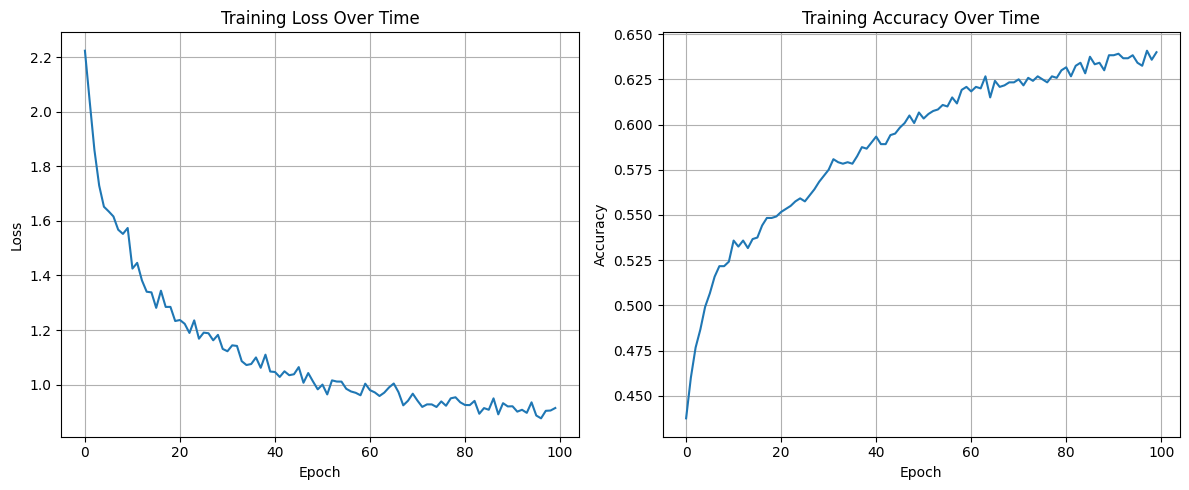

In [13]:
# Visualize training progress
fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize=(12, 5))

loss_plot.plot(loss_history)
loss_plot.set_title("Training Loss Over Time")
loss_plot.set_xlabel("Epoch")
loss_plot.set_ylabel("Loss")
loss_plot.grid(True)

acc_plot.plot(accuracy_history)
acc_plot.set_title("Training Accuracy Over Time")
acc_plot.set_xlabel("Epoch")
acc_plot.set_ylabel("Accuracy")
acc_plot.grid(True)

plt.tight_layout()
plt.show()

Final Test Accuracy: 0.580


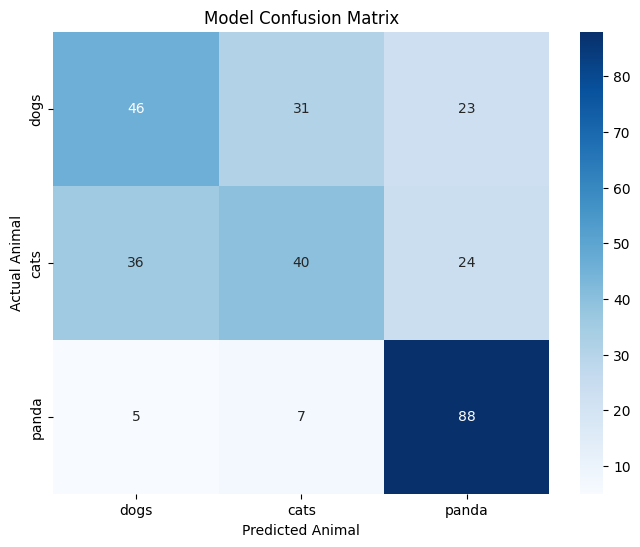

In [14]:
# -----------------------------
# Evaluate model performance
# -----------------------------
test_predictions = animal_net.predict_classes(X_test_reduced)

accuracy_score = np.mean(test_predictions == y_test)
print(f"Final Test Accuracy: {accuracy_score:.3f}")

# Create and display confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=animal_types, yticklabels=animal_types)
plt.title('Model Confusion Matrix')
plt.ylabel('Actual Animal')
plt.xlabel('Predicted Animal')
plt.show()